**Group members:** Christian Lund Sørensen, Morten Esketveid Rasmussen & Thor Donsby Noe.

***Exercises:***

1.1.8 *done*

1.1.11*done*

1.1.13 *done*

2.1.2 *done*

2.2.4 *done*

2.2.5 *done*

3.1.2 *done*

4.2.1 *done*

# Assignment 1


### Practical info
* Handin in absalon. The deadline is the 5th of march (see the [course plan](https://github.com/abjer/tsds/wiki/Course-plan))
* You must work in groups of 2-4. **Remember to identify the group members in the filename or in the top of the file contents**.
* If anything is unclear dont hesitate to email me at kuol@econ.ku.dk with questions.

<br>

<br>
<br>
<br>
<br>

# Questions from exercise set 1 (ML recap)
The following questions are drawn from exercise set 1. We have included code that allows you to solve the questions independently of the previous questions in exercise set 1. Note that you might have solved the questions in a different way than we anticipated. In this case the supplied code might need some modification to work with your answer. 

In [3]:
# Note: there are three .zip files with letter = a,b,c. 
# To ensure the files download in reasonable time we 
# only work with the first of the three. If you have time
# you can modify this cell to download all three. 

import os
import requests

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler        # scales variables to be mean=0,sd=1
from sklearn.linear_model import LogisticRegression     # regression model
from sklearn.pipeline import Pipeline                   # For building our model pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score



filenames = []
base_url = 'https://resources.lendingclub.com/'

letter = 'a'
filename = f'LoanStats3{letter}.csv.zip'
url = base_url+filename

if not os.path.exists(filename):
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)
filenames.append(filename)

# Read in csv files, store them
dfs = [pd.read_csv(f,header=0,skiprows=1,low_memory=False) for f in filenames]

# concatenate the dataframes (as standard there is only 1)
df = pd.concat(dfs)\
        .dropna(subset=['loan_amnt'])\
        .dropna(axis=1, how='all')


# Identify loans of interest
df = df.loc[df.loan_status.isin(['Fully Paid', 'Charged Off'])].copy()

# Clean up variables 
df['charged_off'] = (df.loan_status=='Charged Off').astype(int)
df['int_rate_f'] = df.int_rate.str[:-1].astype(float)
df['emp_length_f'] = df.emp_length\
                        .str.split(' ')\
                        .str[0].str[:2]\
                        .str.replace('<','0')\
                        .astype(float)

# label and features
y_var = 'charged_off'
X_vars = ['term', 'int_rate_f', 'grade', 'home_ownership', 'emp_length_f',
          'annual_inc', 'verification_status', 'dti']

# Create dummies
data = pd.get_dummies(df[X_vars+[y_var]], drop_first=True)\
        .dropna()\
        .reset_index(drop=True)\
        .astype(np.float64)\
        .loc[:2000]\
        .copy()


sss = StratifiedShuffleSplit(n_splits=10, test_size=.3, random_state=3)

# These are the row indices of the stratified split
data_splits = list(sss.split(data[y_var], data[y_var]))

# Separate data in y,X
y = data[y_var]
X_vars_b = data.columns!=y_var
X = data.loc[:,X_vars_b]

train_idx, test_idx = data_splits[0]

y_train = y.loc[train_idx]
X_train = X.loc[train_idx]

y_test = y.loc[test_idx]
X_test = X.loc[test_idx]


# Fit vanilla linear model
lr = Pipeline([('scale', StandardScaler()),
               ('clf', LogisticRegression(class_weight='balanced',C=10**10, solver = 'liblinear'))])


lr.fit(X_train, y_train)


# Fit linear model with CV
lr_cv = GridSearchCV(estimator=lr,
                     param_grid={'clf__C':np.logspace(-4,4,5)},
                     n_jobs=-1,
                     cv=3)
lr_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=10000000000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

**Ex. 1.1.8:** Apply nested resampling to compute a distribution of test scores with and without optimization. You should use `data_splits` which we defined initially and input all the data.
>
>> *Hint:* You can implement this using your code from Ex. 1.1.6 and combine it with `cross_val_score`. Note that `cv` input should use `data_splits`. See Raschka pp. 188-189 for inspiration. 

In [0]:
# [Answer to ex.1.1.8 here]

In [5]:
scores = cross_val_score(lr_cv, X, y,
                          scoring='accuracy', cv=data_splits)
print(scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

[0.63394343 0.67221298 0.68219634 0.64559068 0.63893511 0.64891847
 0.62063228 0.66222962 0.63727121 0.64559068]
CV accuracy: 0.649 +/- 0.018


**Ex. 1.1.11** Estimate a classification tree on the training data (with default hyperparameters). Evalate both on training and test data by computing the *area under the curve*.
>
>> *Hint:* You can check out code for Ex. 1.1.10 for inspiration. You may also want to look up `roc_auc_score`.

In [0]:
# [Answer to ex.1.1.11 here]

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

ct = DecisionTreeClassifier()
ct.fit(X_train, y_train)
y_pred_test = ct.predict(X_test)
y_pred_train = ct.predict(X_train)

print(roc_auc_score(y_test, y_pred_test))
print(roc_auc_score(y_train, y_pred_train))

0.5225415263536267
1.0


**Ex. 1.1.13** Is Random Forest classification different from the procedure of aggregating tree predictions above? If so, explain how.

In [0]:
# [Answer to ex.1.1.13 here]

> **Answer: **  They are different. RF also bootstraps which features to use; this is called feature bagging.

<br>
<br>
<br>
<br>

# Questions from exercise set 2 (ANN 1)
The following questions are drawn from exercise set 2. We have included code that allows you to solve the questions independently of the previous questions in exercise set 1. Note that you might have solved the questions in a different way than we anticipated. In this case the supplied code might need some modification to work with your answer.

In [0]:
### First modify the mnist_loader to run for Colab

#### Libraries
# Standard library
import _pickle as cPickle
import numpy as np
from urllib.request import urlretrieve
import gzip, os

class mnist_loader:
  """
  mnist_loader
  ~~~~~~~~~~~~
  A library to load the MNIST image data.  For details of the data
  structures that are returned, see the doc strings for ``load_data``
  and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
  function usually called by our neural network code.
  """

  def load_data(self):
      """Return the MNIST data as a tuple containing the training data,
      the validation data, and the test data.
      The ``training_data`` is returned as a tuple with two entries.
      The first entry contains the actual training images.  This is a
      numpy ndarray with 50,000 entries.  Each entry is, in turn, a
      numpy ndarray with 784 values, representing the 28 * 28 = 784
      pixels in a single MNIST image.
      The second entry in the ``training_data`` tuple is a numpy ndarray
      containing 50,000 entries.  Those entries are just the digit
      values (0...9) for the corresponding images contained in the first
      entry of the tuple.
      The ``validation_data`` and ``test_data`` are similar, except
      each contains only 10,000 images.
      This is a nice data format, but for use in neural networks it's
      helpful to modify the format of the ``training_data`` a little.
      That's done in the wrapper function ``load_data_wrapper()``, see
      below.
      """
      # download mnist dataset if not available in working directory
      if not os.path.exists('mnist.pkl.gz'):
        urlretrieve('http://deeplearning.net/data/mnist/mnist.pkl.gz','mnist.pkl.gz')
      f = gzip.open('mnist.pkl.gz', 'rb')
      training_data, validation_data, test_data = cPickle.load(f, encoding='bytes')
      f.close()
      return (training_data, validation_data, test_data)

  def load_data_wrapper(self):
      """Return a tuple containing ``(training_data, validation_data,
      test_data)``. Based on ``load_data``, but the format is more
      convenient for use in our implementation of neural networks.
      In particular, ``training_data`` is a list containing 50,000
      2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
      containing the input image.  ``y`` is a 10-dimensional
      numpy.ndarray representing the unit vector corresponding to the
      correct digit for ``x``.
      ``validation_data`` and ``test_data`` are lists containing 10,000
      2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
      numpy.ndarry containing the input image, and ``y`` is the
      corresponding classification, i.e., the digit values (integers)
      corresponding to ``x``.
      Obviously, this means we're using slightly different formats for
      the training data and the validation / test data.  These formats
      turn out to be the most convenient for use in our neural network
      code."""
      tr_d, va_d, te_d = self.load_data()
      training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
      training_results = [self.vectorized_result(y) for y in tr_d[1]]
      training_data = list(zip(training_inputs, training_results))
      validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
      validation_data = list(zip(validation_inputs, va_d[1]))
      test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
      test_data = list(zip(test_inputs, te_d[1]))
      return (training_data, validation_data, test_data)

  def vectorized_result(self, j):
      """Return a 10-dimensional unit vector with a 1.0 in the jth
      position and zeroes elsewhere.  This is used to convert a digit
      (0...9) into a corresponding desired output from the neural
      network."""
      e = np.zeros((10, 1))
      e[j] = 1.0
      return e
  

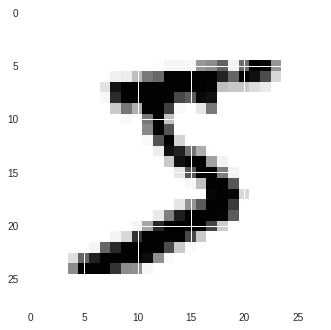

In [10]:
import numpy as np
import random
import matplotlib.pylab as plt
from scipy.interpolate import interp1d

# Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

def step(z, threshold=0.5):
    if z > threshold:
        return 1
    return 0

# Feed forward neural network class
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        
        # Q: Print these out, explain their contents. You can instantiate a network by
        # doing `net = Network([2, 3, 1])`, and then printing `net.biases`.
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        
        # Q: What is `a`? How many iterations will this loop run? For a `sizes=[2, 3, 1]`
        # network, what is the shape of `a` at each iteration?
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, silent=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        
        n = len(training_data)
        if test_data:
            n_test = len(test_data)
        
        for j in range(epochs):
            
            # Q: What happens here? Why do we shuffle the training data? Explain the
            # contents of `mini_batches`.
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            
            # Q: And what does this step do?
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            if not silent:
                if test_data:
                    print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
                else:
                    print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        
        # Q: These two vectors correspond to -∇C(W) (and -∇C(b))
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # Q: But what happens here? Explain, in particular, how we update `nabla_b` and `nabla_w`
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        # Q: Now we have our gradient vectors, `nabla_b` and `nabla_w`. Explain how we use them
        # to update the weights and biases
        self.weights = [
            w - eta / len(mini_batch) * nw
            for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - eta / len(mini_batch) * nb
            for b, nb in zip(self.biases, nabla_b)
        ]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book. Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on. It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        if self.sizes[-1] == 1:
            test_results = [
                (step(self.feedforward(x)), y)
                for x, y in test_data
            ]
        else:
            test_results = [
                (np.argmax(self.feedforward(x)), y)
                for x, y in test_data
            ]
        return test_results, sum(int(y_pred == y) for (y_pred, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return output_activations - y


# Load in the MNIST data used for ex. 2.2.x    
training_data, validation_data, test_data = mnist_loader().load_data_wrapper()
plt.imshow(training_data[0][0].reshape(28, 28))
plt.show()

**Ex. 2.1.2** Using [the dataset](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.16631&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) with the hard-to-seperate circles, create the minimal neural network that seperates the clusters. Again, report your answer with a link.

In [0]:
# [Answer to ex. 2.1.2 here]

> **Answer:** Feeding in $x_1$ and $x_2$ values, [a single hidden layer with 3 neurons](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=3&seed=0.16631&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) is sufficient. As seen the dots can basicly be separated by drawing three linear functions, hence convergence is quick as should be expected.

**Ex. 2.2.4**: Now, fit a model with a suiting architecture (i.e. `sizes`) to `training_data`, and report your accuracy on the `validation_data`.

In [0]:
# [Answer to ex. 2.2.4 here]

In [13]:
net_numbers = Network([784,30,10])
net_numbers.SGD(training_data = training_data, epochs = 5, mini_batch_size = 10, eta = 3, test_data=None, silent=False)
test_results, test_sum = net_numbers.evaluate(validation_data)
print(test_sum/len(validation_data))

Epoch 0 complete
Epoch 1 complete
Epoch 2 complete
Epoch 3 complete
Epoch 4 complete
0.9455


**Ex. 2.2.5**: Assuming you could get a "pretty" high accuracy in Ex. 2.2.4, Visualize 10 examples that get misclassified (remember to write what the correct label is). comment on what you see.

In [0]:
# [Answer to ex. 2.2.5 here]

   ypred  y  equal
5      9  4  False


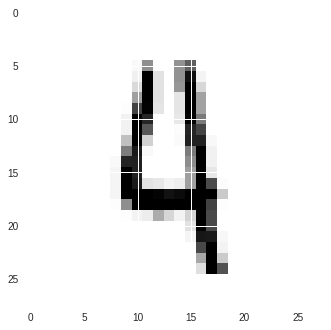

    ypred  y  equal
78      3  9  False


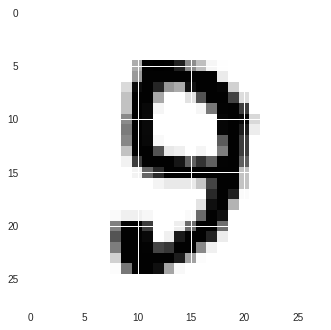

    ypred  y  equal
79      4  9  False


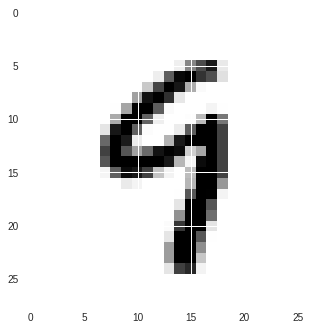

    ypred  y  equal
88      1  9  False


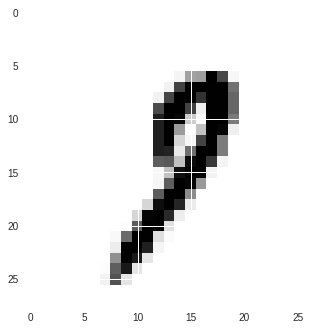

    ypred  y  equal
90      3  4  False


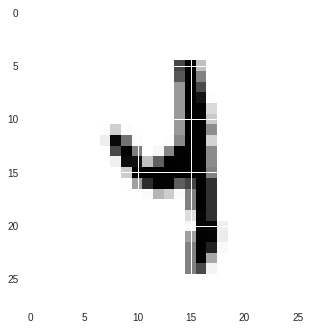

    ypred  y  equal
91      6  5  False


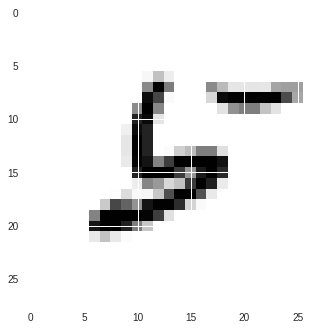

     ypred  y  equal
120      4  1  False


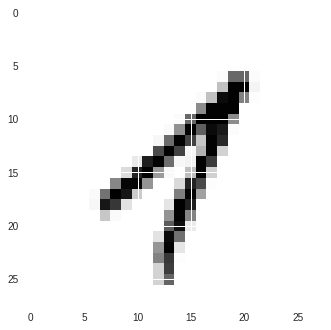

     ypred  y  equal
149      6  4  False


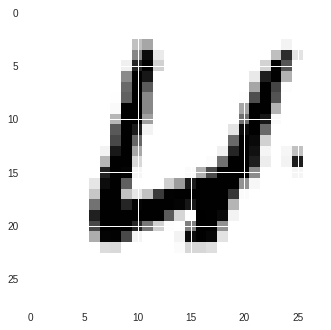

     ypred  y  equal
212      8  3  False


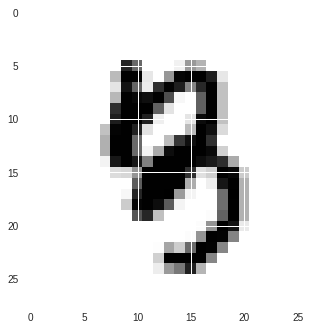

     ypred  y  equal
217      5  9  False


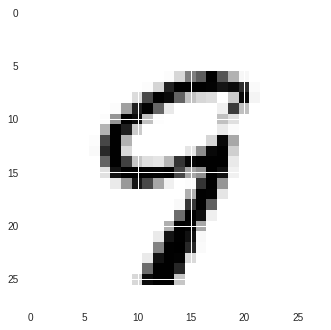

In [15]:
df = pd.DataFrame(test_results, columns=['ypred', 'y'])
df['equal']=df['ypred']==df['y']
k=df.index[df['equal'] == False].tolist()
for i in k[:10]:
    print(df.iloc[[i]])
    plt.imshow(validation_data[i][0].reshape(28, 28))
    plt.show()

<br>
<br>
<br>
<br>

# Questions from exercise set 3 (ANN 2)
The following questions are drawn from exercise set 3. 

![img](https://raw.githubusercontent.com/abjer/tsds/master/material_exercises/week_3/2_3_1_net.png)

![img](https://raw.githubusercontent.com/abjer/tsds/master/material_exercises/week_3/2_3_1_net_compgraph_forward.png)

**Ex. 3.1.2**: Knowing about backpropagation, we actually have everything we need here to compute the gradients of the weights by hand. So go ahead and do that. Report your answer either as a diagram that includes the gradients (you can draw on my figure somehow and insert the resulting image), or just by writing what the gradient of each weight is.
>
> *Hint: When computing gradients with backprop, it can be a bit easier to think of the network as a computational graph. My computational graph looks like this

![img](https://github.com/abjer/tsds/blob/master/material_exercises/week_3/2_3_1_net_compgraph.png?raw=true)

In [0]:
# [Answer to ex. 3.1.2]

In [17]:
# Calculator:
def sigmoid(z):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

z = 0.92
print(sigmoid_prime(z), sigmoid_prime(z)*0.58)

0.20375689277568432 0.1181789978098969


The gradients are calculated using backpropagation, i.e. iteratively applying the chain rule. The example below shows how we calculate the gradient of the loss wrt. the weight of $x_0$ in the first layer: 
    $$ \frac{\partial C}{\partial w_{0,0} } = \frac{\partial C }{\partial \sigma(z)} \cdot \frac{\partial \sigma(z_1) }{\partial  z_1 } \cdot \frac{\partial z_1 }{\partial \sigma(z_0) } \cdot \frac{\partial \sigma(z_0)}{\partial z_0 } \cdot  \frac{\partial  z_0}{\partial w_{0,0} } $$ 

Doing so for each of the weights and biases in the network yields: 

$w_{0,0} = 0.58*0.71*0.29*12*0.99*0.01*4 = 0.057$

$w_{1,0} = 0.58*0.71*0.29*12*0.99*0.01*2 = 0.028$

$b_{0,0} = 0.58*0.71*0.29*12*0.99*0.01 = 0.014$

$w_{i,0} = 0, i = 2,3,4,5 $

$b_{j,0} = 0, j = 1,2$

$b_{0,1} = 0.58 * 0.71*(1-0.71) = 0.119$

$w_{0,1} = 0.58*0.71*(1-0.71)*0.99 = 0.118$

$w_{1,1} = 0.58*0.71*(1-0.71)*1 = 0.119$

$w_{2,1} = 0$ 

Where $w_{k,l}$ denotes the $k^{th}$ weight in the $l^{th}$ layer. 

<br>
<br>
<br>
<br>

# Questions from exercise set 4 (ANN 3)
The following questions are drawn from exercise set 4. Once again we provide you the code required to answer the question.


0 | loss: 845.5892333984375 | fraction correct: 0.0
100 | loss: 507.4726867675781 | fraction correct: 0.325
200 | loss: 403.56884765625 | fraction correct: 0.405
300 | loss: 360.6503601074219 | fraction correct: 0.465
400 | loss: 399.76116943359375 | fraction correct: 0.435
500 | loss: 437.0401916503906 | fraction correct: 0.335
600 | loss: 377.68963623046875 | fraction correct: 0.44
700 | loss: 407.3629455566406 | fraction correct: 0.405
800 | loss: 391.7528076171875 | fraction correct: 0.46
900 | loss: 324.7998046875 | fraction correct: 0.525
1000 | loss: 346.12451171875 | fraction correct: 0.455
1100 | loss: 325.4684143066406 | fraction correct: 0.545
1200 | loss: 377.3672790527344 | fraction correct: 0.445
1300 | loss: 339.01751708984375 | fraction correct: 0.49
1400 | loss: 283.9674377441406 | fraction correct: 0.605
1500 | loss: 273.5011291503906 | fraction correct: 0.595
1600 | loss: 333.3470458984375 | fraction correct: 0.535
1700 | loss: 300.679931640625 | fraction correct: 0.

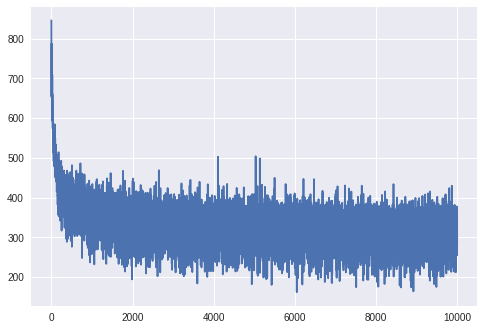

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable

# Download the data (thanks MIT)
response = requests.get("http://shakespeare.mit.edu/hamlet/full.html")
hamlet = BeautifulSoup(response.content, "html.parser").getText()

# Convert text to character-level one-hot encoding
hamlet_one_hot = pd.get_dummies(pd.Series(list(hamlet)))
character_vec = hamlet_one_hot.columns
x = torch.from_numpy(hamlet_one_hot.values.astype(np.float32))


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        
        # Parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # Neural network layers. Rather than giving the input as a one-hot
        # vector, we represent it as a point in a high-dimensional space (i.e.
        # "an embedding"). This tends to work better.
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input_, hidden):
        signal = self.encoder(input_).view(1, 1, -1)  # Embed input character
        output, hidden = self.rnn(signal, hidden)     # Get output and hidden vector(s)
        prediction = self.decoder(output.view(1, -1)) # Decode to "prediction" vector
        
        return prediction, hidden

    def init_hidden(self):
        return (
            torch.autograd.Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
            torch.autograd.Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        )

epochs = 10000
seq_len = 200
learning_rate = 1e-2
n_layers = 2

model = RNN(len(character_vec), 100, len(character_vec), n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# We're collecting the losses so we can plot how they (hopefully) decrease over time
all_losses = []
fraction_correct = []
for t in tqdm(range(epochs)):
    
    # Initiate a hidden vector for 
    hidden = model.init_hidden()
    
    # Pick a random input and output sequence. Here we are only taking one sequence
    # per epoch, but normally people take a batch of sequences.
    # Check https://github.com/spro/char-rnn.pytorch for an example on how to do that
    i = np.random.randint(0, x.size(0)-seq_len)
    input_ = torch.max(x[i:i+seq_len], 1)[1]      # torch.max(...)[1] gets the character in terms of its index, so
    target = torch.max(x[i+1:i+1+seq_len], 1)[1]  # input_ will be something like torch.tensor([2, 1, 4, 0, ... 1])
    
    # Backprop through time. Here we are just summing the losses from each timestep
    # and do backpropagation on the variable that holds the sum. PyTorch allows for that
    optimizer.zero_grad()
    loss = 0
    correct = 0
    for j in range(input_.size(0)):
        output, hidden = model(input_[j], hidden)
        loss += loss_fn(output.view(1, -1), target[j].view(1, ))
        correct += int(torch.max(output.view(1, -1), 1)[1][0] == target[j])
    
    # SGD step
    loss.backward()
    optimizer.step()
    
    # Collect loss value for plot
    all_losses.append(float(loss))
    fraction_correct.append(correct / input_.size(0))
        
    # Progress
    if t % 100 == 0:
        print(t, "| loss:", float(loss), "| fraction correct:", fraction_correct[-1])

    
plt.plot(all_losses)
plt.show()

> **Ex. 4.2.1**: Train the network for a while (the longer the better) until you feel its error has settled in some local minimum. Then go ahead and generate some gibberish Hamlet with it! To get better results, you can "warm up" the hidden state vectors by first running a sequence of actual Shapespeare through it and then starting generating from the last word in that sequence. Also, what I mean by "start generating" is that instead of predicting output from inputs drawn from your dataset, you input the prediction from the previous timestep and repeat, thus getting something that's completely made up.

In [0]:
# [Answer to ex. 4.2.1]

In [56]:
### 1st try: Taking the most likely character each time

# Initiating a sentence with each of the letters A, B, and C
for i in range(12, 15):

    char = torch.tensor(i)

    # Initiate a hidden vector
    hidden = model.init_hidden()

    # A container for the text
    storage = [character_vec[char]]

    # Iteratively predict 100 characters from the former
    for _ in range(100):
      pred, hidden = model(char, hidden)
      char = torch.argmax(pred)
      storage.append(character_vec[char])

    # Print the characters before starting over with the next initial letter
    print(''.join(storage), '\n\n---\n')


AUIIUS

I have to the soul of the soul of the soul
The soul of the soul of the soul
The soul of the s 

---

But the some to the soul of the soul
The soul of the soul of the soul
The soul of the soul of the sou 

---

CO
HAMLET

I have to the soul of the soul of the soul
The soul of the soul of the soul
The soul of th 

---



In [79]:
### 2nd try: Introduce a degree of randomness between the most likely characters

# A method to generate the next character (thanks to Albert Lai)
def predict(model, char=12, hidden=None, k=5):
    ''' Taking an intitial character and the hidden state as input.
         Returning the updated hidden state and the next character selected with
         a certain degree of randomness between the more likely characters
         according to the model.
         char=12 corresponds to 'A' (see the the character vector below).
    '''

    # Use the model to predict the probabilities of each character    
    out, hidden = model(char, hidden)
    p = torch.softmax(out, dim=1).data # convert output to positive probabilities

    # Select the k most likely characters
    p, top_ch = p.topk(k)

    # Convert to numpy arrays
    p = p.detach().numpy()
    p = p[0]
    top_ch = top_ch.numpy().squeeze()

    # Select the next character among the top characters wrt. their weighted probability
    char = np.random.choice(top_ch, p=p/p.sum())
    char = torch.tensor(char)
    storage.append(character_vec[char])

    return char, hidden
  
df = pd.DataFrame(character_vec) # for locating the index of the letter

# A method to run the sample
def writer(model, letter='A', length=1000, k=5):
    ''' Taking the model, a single letter, the desired text length as inputs.
        Also set the number k of the most likely character that is drawn from.
        Outputting a text using the predict method above.
    '''

    # Locate the position of the letter in the character_vec
    char_ = df.index[df.iloc[:,0] == letter]
    char = torch.tensor(char_[0])

    # Store the initial character in a container
    storage = [character_vec[char]]

    # Initiate a hidden vector
    hidden = model.init_hidden()
    
    # Use the predict method for predicting the next character from the former
    for _ in range(length):
        char, hidden = predict(model, char, hidden, k)
        storage.append(character_vec[char])

    return ''.join(storage)


# CHOOSE PARAMETERS:
letter = 'A'   # Initial letter
length = 1000  # Length of generated text (in characters)
k = 5          # The number of top-most-likely characters to be drawn from.

print( writer(model, letter, length, k) )

AUIUS

Tills and toplies so most madness
That bodit and the sounded, a cause me,
To but than this thine should man to traver,
And to this so men to the capprefty of meant interss,
That than a meant times show, be too treated so too.
There new or thats of tell, tell speak
To the someting, the propprowieved the
trange and shows and bodiers, this sain.

LORD POLONIUS

Hoips of triffers of this failes the many
Till this blood of the bledinant so,
That soul should something: and he steem, and the
burns of thank to me and this find
To the soul to his parties is soul of
mine and be spoker in.

HAMLET

Alewar intanted this supperstack so meant till
It fassion and broun's in my bound
Of tone to my tone a breason. Fortifies and compart me the chiction
The monn of the craistes of to this:'
As alt thy ploish.

HAMLET

Have me itself me.

REYNALDO

And to tone the morn sun, betruse
This, to his first of your place,
If it will potions of my bear madness off a bountess
If thing it to set, be son and


In [84]:
# How does the quality decay when changing the threshold for inclusion in the draw?
for k in [2,10,20,40,66]:
  print('k =',k,':\n\n', writer(model, 'A', 150, k),'\n')

k = 2 :

 And so majesty,
The soul this soul this soul of the
passion, and the come this suct the can the comment
To the cannon to the come too to the
prainstern 

k = 10 :

 AMAUDIUS
HoR!

LORD POLONIUS

Which time on't.
Brist to faith sometabist me so,
In than thint will in you:
And sprick's blood make it bunked,
To thee n 

k = 20 :

 AUIIUDIUS

These to shoult. Come speaked oftime more of me
the mazy matters
If thoness we mounnore, lust feen, what a prain,
And the call in the mintse 

k = 40 :

 AAROSRIA. Another we sweet in the lands;
Tsometil'd good todeless been
And sounstant of Denmark Heed come time,
I tots in my vonsship if suition are fo 

k = 66 :

 AUIIUS

A suchtly safterstaty mine it walk, I cables:
This to brew if it tempticf
in the waxine, stonefood we and to well, to sound, I an: bewas
ROr
my 



In [50]:
# Overview of the character vector
print(pd.DataFrame(character_vec))

     0
0   \t
1   \n
2     
3    !
4    &
5    '
6    ,
7    -
8    .
9    :
10   ;
11   ?
12   A
13   B
14   C
15   D
16   E
17   F
18   G
19   H
20   I
21   J
22   K
23   L
24   M
25   N
26   O
27   P
28   Q
29   R
..  ..
36   Z
37   [
38   ]
39   a
40   b
41   c
42   d
43   e
44   f
45   g
46   h
47   i
48   j
49   k
50   l
51   m
52   n
53   o
54   p
55   q
56   r
57   s
58   t
59   u
60   v
61   w
62   x
63   y
64   z
65   |

[66 rows x 1 columns]
